<a href="https://colab.research.google.com/github/priyankahubli/Video-prediction-using-VAE-GANs/blob/master/VAE_GAN_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (GANs)

In this lab, we will be working with GANs.

In [47]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

  HTTP error 403 while getting http://download.pytorch.org/whl/cu80/torch-0.4-cp36-cp36m-linux_x86_64.whl
  Could not install requirement torch==0.4 from http://download.pytorch.org/whl/cu80/torch-0.4-cp36-cp36m-linux_x86_64.whl because of error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu80/torch-0.4-cp36-cp36m-linux_x86_64.whl
Could not install requirement torch==0.4 from http://download.pytorch.org/whl/cu80/torch-0.4-cp36-cp36m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu80/torch-0.4-cp36-cp36m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu80/torch-0.4-cp36-cp36m-linux_x86_64.whl


In [0]:
%matplotlib inline
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.models.inception import inception_v3
from torchvision import datasets, transforms
from scipy.stats import entropy
import copy

import itertools

torch.manual_seed(0); #you may want to make use of this in various cells for reproducability
gpu_boole = torch.cuda.is_available()

## 1. Introduction and Motivation

As a recap from lecture:

GANs are a popular architecture class for
generating data first introduced in (Goodfellow et al 2014). 

The two major components of a GAN framework are a Discriminator network $D$ and
a Generator network $G$.

$D$ takes a data sample as input and decides whether it is real (coming from the actual 
training set) or fake (generated artificially). $G$ takes some random noise vector
$z$ as input and outputs a generated sample. 

In practice, these networks "battle": $G$ continually attmepts to generate
more realistic samples and $D$ continually tries to get better at distinguishing
real samples from fake smaples. This can be formulated as a min-max zero sum game:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log 1 - D(G(z))]$$
where $p_z(z)$ denotes a defined prior over the noise vector. Local and global minima for this problem exist at local and global Nash Equilibria.

The hope is that, over training, $D$ becomes a very good discriminator and $G$ becomes
a very good generator. At the end of training, we can then make use of $G$
to generate nice looking samples that seem like they were drawn from the original
distribution.

In [0]:
def MNIST_IS(imgs, model_path='MNIST.ckpt', batch_size=32, splits=10):
    
    """Computes the inception score of the generated images imgs
    imgs -- numpy array of dimension (# of datapoints, 1, 28, 28)
    batch_size -- batch size for feeding into the pretrained MNIST model
    splits -- number of splits
    """
    N = len(imgs)
    
    #check imgs is numpy array & of desired dimension
    assert type(imgs) is np.ndarray
    assert imgs.shape[1] == 1
    assert imgs.shape[2] == 28
    assert imgs.shape[3] == 28
    assert batch_size > 0
    assert N > batch_size
    
    imgs = copy.copy(imgs)
    
    # Set up dtype
    if torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor
    
    MEAN = 0.1307
    STD = 0.3081
    imgs -= MEAN
    imgs /= STD
    
    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    MNIST_model = ConvNet()
    MNIST_model.load_state_dict(torch.load(model_path))
    if torch.cuda.is_available():
        MNIST_model = MNIST_model.cuda()
    MNIST_model.eval()

    def get_pred(x):
        if torch.cuda.is_available():
            x = x.cuda()
        x = MNIST_model(x)
        return F.softmax(x, dim=0).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 10))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

#Model structure of the pretrained MNIST data
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


Now, let's see the inception score for the actual MNIST dataset.

You will need to make sure the provided `MNIST.ckpt` file is in your working directory or specify its path via the `model_path` argument of `MNIST_IS`. If using Google Colab, click `View` --> `Table of Contents` --> `Files` and then upload the `MNIST.ckpt` file.

The cell below gives an IS estimate for some MNIST samples.

In [50]:
transform = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=500, shuffle=True)

for x, y in train_loader:
    x = x
    break
x = x.cpu().data.numpy()
x = x.reshape([-1,1,28,28])
print('Shape of data:',x.shape)
mis = MNIST_IS(x)
print('Inception Score:','mean:',mis[0],'std:',mis[1])

Shape of data: (500, 1, 28, 28)
Inception Score: mean: 9.100985329451802 std: 0.7829245432763191


The score for MNIST should be somewhere around 8 to 12. As we train our GAN(s), we will be looking to
get as high an inception score as possible on our generated images.


### 3.2. Generating MNIST images

As you did with the Gaussian distribution, see if you can train D and G
such that G can generate nice images for MNIST. **You are free to use any architecture class, but keep it fairly computationally inexpensive, if possible.** Simple CNNs are good guidelines for computational tractability.

#### Deliverables

Given the limited computational resources, you will want to achieve an inception score of 1.5 or greater for full credit. An IS of 1.5 won't yield great images. For nice looking images, you'll need an inception score of around 6.0, but it is not needed for full credit.

Scores higher than 1.5 will receive bonus points.

#### Instructions for long training times

For more complicated architectures, if your model takes a long time to train, you will need to save the model and write a code snippet that loads it such that the code runs with no errors and we can grade it expediently. In this case, set epochs = 0 and include the saved model in your submission on blackboard (or a Google drive link / something similar if it is too large for BB).

#### Some Optional Tips

It will be easier to get better results with a convolutional GAN as MLPs are typically not used in practical settings. Deconvolutional layers (implemented via `nn.ConvTranspose2d` in pytorch) are typically used. I suggest paying attention to the shapes at each line of the forward pass to avoid errors.

There are additional GAN architectures online you may want to reference for inspiration. (But do not plagiarize -- please write your own custom network.)

In [0]:
#Defining your networks:

class generator(nn.Module):
    # initializers
    def __init__(self,k):
        super(generator, self).__init__()
        #TO-DO
        self.conv1 = nn.ConvTranspose2d(k, 9, kernel_size=5)  # 5 7 
        self.conv2 = nn.ConvTranspose2d(9, 8, kernel_size=5) # 9  10
        self.conv3 = nn.ConvTranspose2d(8, 7, kernel_size=5) #13  14
        self.conv4 = nn.ConvTranspose2d(7, 6, kernel_size=5) #17   18
        self.conv5 = nn.ConvTranspose2d(6, 5, kernel_size=5)  # 21  22
        self.conv6 = nn.ConvTranspose2d(5, 4, kernel_size=5)  # 25  26
        self.conv7 = nn.ConvTranspose2d(4, 1, kernel_size=4)  # 28  (kernel=3,no outs)
        self.bn1 = nn.BatchNorm2d(9)
        self.bn2 = nn.BatchNorm2d(8)
        self.bn3 = nn.BatchNorm2d(7)
        self.bn4 = nn.BatchNorm2d(6)
        self.bn5 = nn.BatchNorm2d(5)
        self.bn6 = nn.BatchNorm2d(4)
        self.bn7 = nn.BatchNorm2d(1)
        
        
        self.tanh = nn.Tanh()
        
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        #TO-DO
        x = F.relu(self.bn1(self.conv1(input)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        #x = self.tanh(self.conv7(x))
        return self.tanh(x)
        
        
        
k=10 #feel free to change k

class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        #TO-DO
        self.conv1 = nn.Conv2d(1,5,kernel_size = 7)
        self.conv2 = nn.Conv2d(5,10,kernel_size = 7)
        self.conv3 = nn.Conv2d(10,20,kernel_size = 7)
        self.conv4 = nn.Conv2d(20,30,kernel_size = 7)
        self.conv5 = nn.Conv2d(30,40,kernel_size = 4)
               
        self.linear1 = nn.Linear(480,200)
        self.linear2 = nn.Linear(200,100)
        self.linear3 = nn.Linear(100,10)
        self.linear4 = nn.Linear(10,1)
        
        
        self.sigmoid = nn.Sigmoid()
        self.bn1 = nn.BatchNorm2d(5)
        self.bn2 = nn.BatchNorm2d(10)
        self.bn3 = nn.BatchNorm2d(20)
        self.bn4 = nn.BatchNorm2d(30)
        self.bn5 = nn.BatchNorm2d(40)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        #TO-DO
        x = F.relu(self.bn1(self.conv1(input)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(-1, 480)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        
                     
        x = self.sigmoid(x)
        
        return x.squeeze()
        
        

        

In [0]:
class VAE_encoder(nn.Module):
    def __init__(self):
        super(VAE_encoder, self).__init__()
        intermediate_channels = 32
        z_dims = k
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2, bias=True)    
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=2, bias=True)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv5 = nn.Conv2d(64, intermediate_channels, kernel_size=3, stride=2, padding=1, bias=True)

        
        self.conv_mu = nn.Conv2d(intermediate_channels, z_dims, kernel_size=2, stride=1, padding=0)
        self.conv_logvar = nn.Conv2d(intermediate_channels, z_dims, kernel_size=2, stride=1, padding=0)
        
 
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(intermediate_channels)
        
    def forward(self, x):
        #print('initial: ', x.shape)
        x = F.relu(self.bn1(self.conv1(x)))
        #print('After conv1: ', x.shape)
        x = F.relu(self.bn2(self.conv2(x)))
        #print('After conv2: ', x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
        #print('After conv3: ', x.shape)
        x = F.relu(self.bn4(self.conv4(x)))
        #print('After conv4: ', x.shape)
        x = F.relu(self.bn5(self.conv5(x)))
        #print('After conv5: ', x.shape)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)

        return mu, logvar
    def rsample(self, mu, logvar):
        m = torch.distributions.Normal(mu, torch.exp(logvar * 0.5))
        return m.rsample()

The training code is below. Feel free to modify  it.

Training start!
Epoch:  0
[1/2] - loss_d: 1.386, loss_g: 0.693
Epoch:  1
[2/2] - loss_d: 1.386, loss_g: 0.693


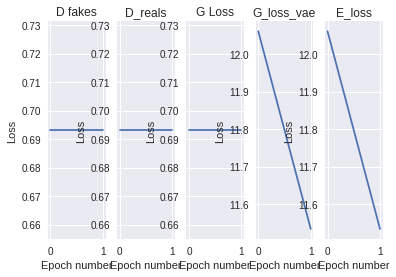

In [56]:
#Training code:

gpu_boole = torch.cuda.is_available()
cnn_boole = True #set True for CNN reshaping. False otherwise.
epochs = 2
batch_size = 32 
lr = 0.2

G = generator(k)
D = discriminator()
E = VAE_encoder()

if gpu_boole:
    G = G.cuda()
    D = D.cuda()
    E = E.cuda()
    
#data loader:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

#D,G optimizers:
G_optimizer = optim.SGD(G.parameters(), lr=lr)
D_optimizer = optim.SGD(D.parameters(), lr=lr)
E_optimizer = optim.SGD(E.parameters(), lr=lr)

#loss definition(s):
BCE_loss = nn.BCELoss()

def loss_function(real_l,fake_l, mu, logvar):
    
    
    diff = real_l - fake_l
    L2 = torch.sum(torch.mul(diff, diff))/batch_size
    
    #L2 = log_p_x_given_z(reconstruction, sigma_x, data)
    
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  #TODO-----------------------

    return L2 + KLD
#training loop:
D_losses = []
G_losses = []
D_fakes = []
D_reals = []
G_loss = []
G_loss_vae = []
E_loss = []
print("Training start!")

for epoch in range(epochs):
    print('Epoch: ',epoch)
    for x_, _ in train_loader:
        
        #reshaping depending on your architecture class:
        if not cnn_boole:
            x_ = x_.view(batch_size,-1) #this reshape is needed for MLP class
        if gpu_boole:
            x_ = x_.cuda()
        
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        if gpu_boole:
            y_real_ = y_real_.cuda()
            y_fake_ = y_fake_.cuda()

        x_, y_real_, y_fake_ = Variable(x_), Variable(y_real_), Variable(y_fake_)
        D_result = D(x_)
        D_result_real = D_result
        D_real_loss = BCE_loss(D_result, y_real_)

        #z_ = torch.randn((mini_batch, k))
        mu, logvar = encoder(x_)
        latent = encoder.rsample(mu, logvar)
        z_ = latent 
        
        #print('z: ',z_.shape)
        if cnn_boole:
            z_ = z_.view(-1, k, 1, 1) #needed for CNN        
        z_ = Variable(z_)
        if gpu_boole:
            z_ = z_.cuda()

        G_result = G(z_)
        D_result = D(G_result)
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        #D_train_loss = D_real_loss + D_fake_loss
        D_real_loss.backward(retain_graph = True)
        D_fake_loss.backward(retain_graph = True)
        #D_train_loss.backward(retain_graph = True)
        
        D_optimizer.step()
        
        D_losses.append(D_train_loss.data.item())
        
        # train generator G
        G.zero_grad()

        #z_ = torch.randn((mini_batch, k))
        mu, logvar = encoder(x_)
        latent = encoder.rsample(mu, logvar)
        z_ = latent 
        
        if cnn_boole:
            z_ = z_.view(-1, k, 1, 1) #needed for CNN
        z_ = Variable(z_)
        if gpu_boole:
            z_ = z_.cuda()

        G_result = G(z_)
        D_result = D(G_result).squeeze()
        D_result_fake = D_result
        G_train_loss = BCE_loss(D_result, y_real_) 
        G_train_loss_vae = loss_function(D_result_real, D_result_fake, mu, logvar)
        
        G_train_loss.backward(retain_graph = True)
        G_train_loss_vae.backward(retain_graph = True)
        
        G_optimizer.step()

        G_losses.append(G_train_loss.data.item())
    
        # train encoder 
        E.zero_grad()
        
        E_train_loss = loss_function(D_result_real, D_result_fake, mu, logvar)
        E_train_loss.backward(retain_graph = True)
        E_optimizer.step()
    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), epochs, torch.mean(torch.FloatTensor(D_losses)),
                                                                  torch.mean(torch.FloatTensor(G_losses))))
    D_fakes.append(D_fake_loss)
    D_reals.append(D_real_loss)
    G_loss.append(G_train_loss)
    G_loss_vae.append(G_train_loss_vae)
    E_loss.append(E_train_loss)

   

#Plotting:

#Losses:
plt.subplot(1, 5, 1)
plt.plot(D_fakes)
plt.title("D fakes")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.subplot(1, 5, 2)
plt.plot(D_reals)
plt.title("D_reals")
plt.xlabel("Epoch number")
plt.ylabel("Loss");
plt.subplot(1, 5, 3)
plt.plot(G_loss)
plt.title("G Loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss");plt.subplot(1, 5, 4)
plt.plot(G_loss_vae)
plt.title("G_loss_vae")
plt.xlabel("Epoch number")
plt.ylabel("Loss");
plt.subplot(1, 5, 5)
plt.plot(E_loss)
plt.title("E_loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss");

##### Computing inception score:

In [43]:
# Samples from G:
z_ = torch.randn((1500, k))
z_ = Variable(z_)
if gpu_boole:
    z_ = z_.cuda()
if cnn_boole:
    z_ = z_.view(-1, k, 1, 1) #needed for CNN        
    
G_result = G(z_)
G_result = G_result.cpu().data.numpy()
G_result = G_result.reshape([1500,1,28,28])

mis = MNIST_IS(G_result)
print('Inception Score:','mean:',mis[0],'std:',mis[1])

Inception Score: mean: 1.1322978184738781 std: 0.012858801156764823


##### Visualizing GAN samples

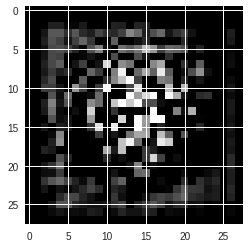

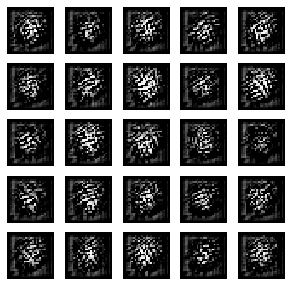

In [46]:
# Samples from G:
z_ = torch.randn((1500, k))
z_ = Variable(z_)
if gpu_boole:
    z_ = z_.cuda()
if cnn_boole:
    z_ = z_.view(-1, k, 1, 1) #needed for CNN        

G_result = G(z_)
G_result = G_result.cpu().data.numpy()
G_result = G_result.reshape([1500,28,28])

plt.imshow(G_result[0],cmap='gray')

size_figure_grid = 5
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)

for kr in range(5*5):
    i = kr // 5
    j = kr % 5
    ax[i, j].cla()
    ax[i, j].imshow(G_result[kr], cmap='gray')


In [0]:
torch.save({'epoch':epochs,'gen_state_dict': G.state_dict(),'disc_state_dict': D.state_dict()},'trained.cpkt')

In [29]:
# To load the model from file :


G = generator(k)
D = discriminator()


G = G.cuda()
D = D.cuda()

checkpoint = torch.load('trained.cpkt')
G.load_state_dict(checkpoint['gen_state_dict'])
D.load_state_dict(checkpoint['disc_state_dict'])


FileNotFoundError: ignored